In [2]:
# Import relevant packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

# **Detecting sea level rise from Florida tide gauge records**
### Practice with Pandas time series analysis

<!-- ![sea_level_rise.JPG](sea_level_rise.JPG) -->
<img src="sea_level_rise.JPG" width="1200px"/>

<div style="border: 2px solid teal; padding: 10px; background-color: #f0f8ff; margin-top: 10px;">
  <strong><font color='teal'>Exercise motivation and objectives: </font></strong><br><font color='black'>The historical tide gauge record from Key West, FL, spans over a century, but its current hourly resolution exhibits significant short-term fluctuations. This makes it difficult to detect longer-term patterns such as annual, interannual, or decadal variability. In this exercise, we will:
  <ul>
    <li>Practice smoothing time series data in pandas using <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.resample.html" target="_blank"><code>.resample()</code></a>, <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.rolling.html" target="_blank"><code>.rolling()</code></a>, and <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.groupby.html" target="_blank"><code>.groupby()</code></a>.</li>
    <li>Identify advantages and limitations of each function, and discuss how to select the function most appropriate for your task.</li>
    <li>If time: Practice adding error bars to a figure using matplotlib's <a href="https://matplotlib.org/3.7.1/api/_as_gen/matplotlib.pyplot.errorbar.html" target="_blank"><code>.errorbar()</code></a> function.</li>
  </ul>
  </font>
</div>
<br>

**Data description:** A netCDF file with hourly tide gauge records from Key West, FL (from 1913 to present). The tide gauge measurements are of relative sea level (RSL), which includes both sea level rise (from ice melt and thermal expansion) and local vertical land motion (from subsidence and isostatic rebound).

**Data source:** [University of Hawaii Sea Level Center](https://uhslc.soest.hawaii.edu/datainfo/)

## Step 1: Load the data

1. Open the Key West data file using xarray and display it.
<div style="border: 2px solid teal; padding: 5px; background-color: #f0f8ff; margin-top: 10px; margin-left: 1em; margin-bottom: 10px;">    
<strong><font color='teal'><i>Why? </i></font></strong>&nbsp;<font color='black'>Our data is a netCDF (.nc) file. xarray <a href="https://docs.xarray.dev/en/v2023.08.0/generated/xarray.open_dataset.html" target="_blank"><code>open_dataset()</code></a> is usually the easiest way to open .nc files.</font>
</div>
2. Convert the data file to a pandas `DataFrame`.
<div style="border: 2px solid teal; padding: 5px; background-color: #f0f8ff; margin-top: 10px; margin-left: 1em; margin-bottom: 10px;">    
<strong><font color='teal'><i>Why? </i></font></strong>&nbsp;<font color='black'>After opening, we see that the data has two dimensions: <code>time: 979146</code> and <code>record_id: 4</code>. From the xarray metadata, we see that the data is primarily 1-D in time, as <code>record_id</code> is just a station identifier. It is easier to work with 1-D data in pandas than in xarray, so we convert the data to a pandas <code>DataFrame</code> object using the xarray <a href="https://docs.xarray.dev/en/v2023.08.0/generated/xarray.DataArray.to_dataframe.html" ><code>.to_dataframe()</code></a> function.</font>
</div>
3. Extract the sea level time series from Key West, FL, as a pandas `Series` and display it. (Hint: drop the `record_id` index level!)
<div style="border: 2px solid teal; padding: 5px; background-color: #f0f8ff; margin-top: 10px; margin-left: 1em; margin-bottom: 10px;">    
<strong><font color='teal'><i>Why? </i></font></strong>&nbsp; <font color='black'>Our data has been converted to a <code>DataFrame</code> with a <code>MultiIndex</code> (multidimensional index). While we could use the <code>record_id</code> index to subset our data, we see that there is a <code>station_name</code> variable that will be easier to subset with, so we can go ahead and drop the <code>record_id</code> index using <a href="https://docs.xarray.dev/en/v2023.08.0/generated/xarray.DataArray.to_dataframe.html" ><code>.droplevel()</code></a>. We then use <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.DataFrame.loc.html" ><code>.loc[]</code></a> to select just the rows with data from Key West, FL. Finally, we extract just the <code>sea_level</code> column, which contains our actual data.</font>
</div>

In [13]:
# set the filepath 
filepath = "data/tide_gauges.nc"

# open with xarray
tide_gauges_xr = xr.open_dataset(filepath)
display(tide_gauges_xr)

# convert to pandas dataframe
tide_gauges = tide_gauges_xr.to_dataframe()
# display(tide_gauges)

# drop record id
tide_gauges = tide_gauges.droplevel("record_id")
#display(tide_gauges)

# subset to Key West
key_west = tide_gauges.loc[tide_gauges['station_name'] == "Key West, FL"]
#display(key_west)

# select just the sea level Series
key_west = key_west['sea_level']
display(key_west)

# alternatively, we could do these in one line:
#key_west = tide_gauges.loc[tide_gauges['station_name'] == "Key West, FL", "sea_level"]
#display(key_west)

<xarray.Dataset>
Dimensions:          (time: 979146, record_id: 4)
Coordinates:
  * time             (time) datetime64[ns] 1913-01-19T06:00:00 ... 2024-09-30...
  * record_id        (record_id) int16 2570 7550 7620 2420
Data variables:
    sea_level        (record_id, time) float32 ...
    lat              (record_id) float32 ...
    lon              (record_id) float32 ...
    station_name     (record_id) object ...
    station_country  (record_id) object ...
Attributes:
    title:                  UHSLC Fast Delivery Tide Gauge Data (hourly)
    ncei_template_version:  NCEI_NetCDF_TimeSeries_Orthogonal_Template_v2.0
    featureType:            timeSeries
    Conventions:            CF-1.6, ACDD-1.3
    date_created:           2024-11-07T14:27:39Z
    publisher_name:         University of Hawaii Sea Level Center (UHSLC)
    publisher_email:        philiprt@hawaii.edu, markm@soest.hawaii.edu
    publisher_url:          http://uhslc.soest.hawaii.edu
    summary:                The UHSLC assembles and distributes the Fast Deli...
    processing_level:       Fast Delivery (FD) data undergo a level 1 quality...
    acknowledgment:         The UHSLC Fast Delivery database is supported by ...

time
1913-01-19 06:00:00.000000    1128.0
1913-01-19 07:00:00.028800    1128.0
1913-01-19 07:59:59.971200    1189.0
1913-01-19 09:00:00.000000    1250.0
1913-01-19 10:00:00.028800    1311.0
                               ...  
2024-09-30 19:00:00.028800    1744.0
2024-09-30 19:59:59.971200    1740.0
2024-09-30 21:00:00.000000    1801.0
2024-09-30 22:00:00.028800    1893.0
2024-09-30 22:59:59.971200    1978.0
Name: sea_level, Length: 979146, dtype: float32

## Step 2: Plot the time series from Key West
1. Plot the sea level time series data using `matplotlib`. We'll build off this figure in future steps, so make sure to follow best figure practices.

<div style="border: 2px solid teal; padding: 10px; background-color: #f0f8ff; margin-top: 10px;">
  <strong><font color='teal'><i>Why? </i></font></strong>&nbsp;<font color='black'>Data exploration. Visualizing the data helps us answer important questions such as:<br>
  <ul>
    <li>How much data do we have, and is any data missing?</li>
    <li>Are there any obvious patterns, trends, or outliers?</li>
    <li>What data cleaning steps might be necessary before analysis?</li>
  </ul>
    </font>
</div>

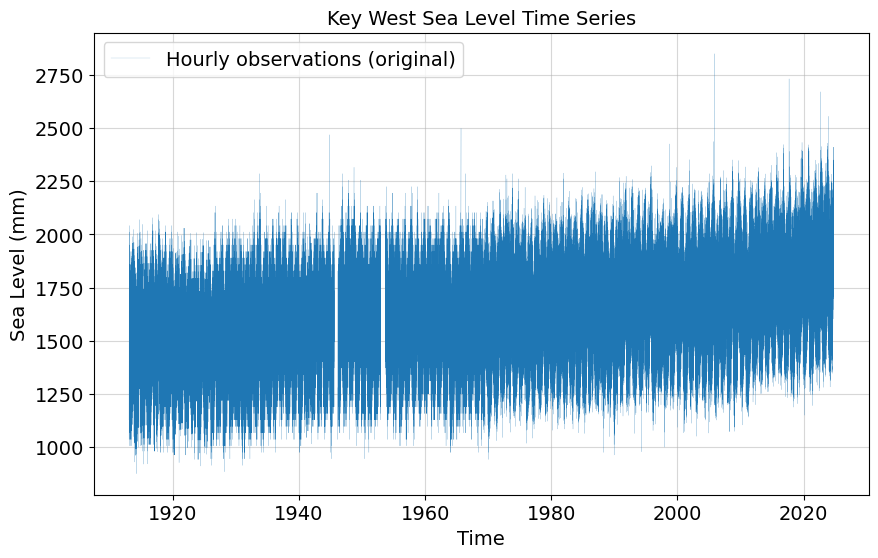

In [19]:
# create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# plot the time series
ax.plot(key_west.index.values, key_west.values, lw=0.1,
        label = "Hourly observations (original)")

# axis labels
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Sea Level (mm)", fontsize=14)

# title for the plot
ax.set_title("Key West Sea Level Time Series", fontsize=14)

# add gridlines
ax.grid(alpha=0.5)

# add legend
ax.legend()

# hack to increase font sizes
plt.rcParams['font.size'] = 14

## Step 3: Calculate annual averages using `.resample()`
1. Calculate the annual means from the time series using <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.resample.html" target="_blank">`.resample()`</a>.
    - <a href="https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#offset-aliases">Offset aliases</a> in pandas. Use this to set the new frequency.
2. Save the resampled data as a new variable named `key_west_annual`. Display it to make sure that it worked.
3. Create a figure comparing the original time series and the resampled annual averages.

<div style="border: 2px solid teal; padding: 10px; background-color: #f0f8ff; margin-top: 10px;">
  <strong><font color='teal'><i>Why? </i></font></strong>&nbsp;<font color='black'>At its current hourly resolution, the data shows strong fluctuations that obscure variability at longer scales (annual, interannual, etc). <i><strong>Resampling</strong></i> a time series means changing the time intervals between data points (i.e., adjusting the frequency). In this case, we'll resample the data to annual resolution to smooth the data so that we can better identify longer-term patterns.</font>
</div>

In [24]:
# resample to annual resolution
key_west_annual = key_west.resample("YS").mean()
#key_west.resample("Y").count()
display(key_west_annual)

time
1913-01-01    1495.438354
1914-01-01    1481.190063
1915-01-01    1479.568359
1916-01-01    1494.357056
1917-01-01    1513.670288
                 ...     
2020-01-01    1806.357544
2021-01-01    1780.467773
2022-01-01    1839.115234
2023-01-01    1843.097168
2024-01-01    1790.943359
Freq: AS-JAN, Name: sea_level, Length: 112, dtype: float32

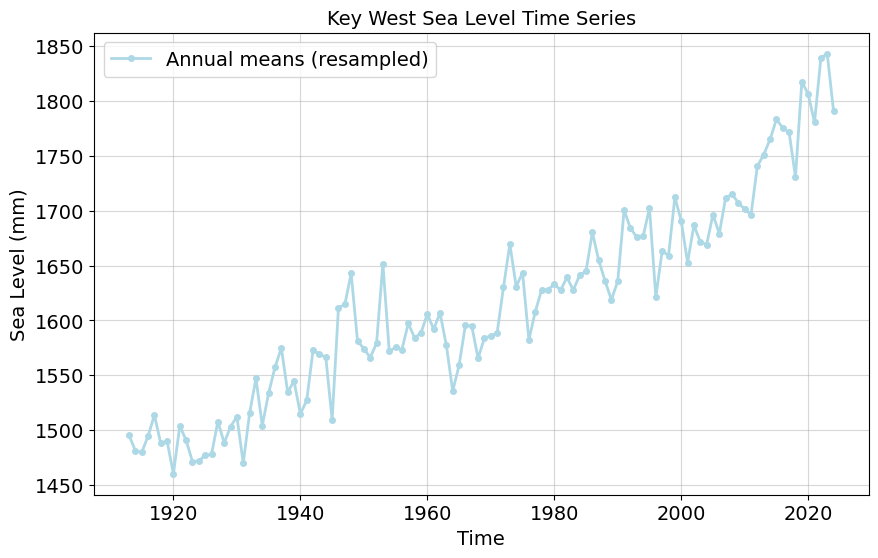

In [26]:
# copy and paste our figure from before, then add to it
# create the figure
fig, ax = plt.subplots(figsize=(10, 6))

# plot the time series
#ax.plot(key_west.index.values, key_west.values, lw=0.1,
#        label = "Hourly observations (original)")

# plot resampled annual values
ax.plot(key_west_annual.index.values, key_west_annual.values,
        '.-', markersize=8, lw=2, c='lightblue', 
        label='Annual means (resampled)')

# axis labels
ax.set_xlabel("Time", fontsize=14)
ax.set_ylabel("Sea Level (mm)", fontsize=14)

# title for the plot
ax.set_title("Key West Sea Level Time Series", fontsize=14)

# add gridlines
ax.grid(alpha=0.5)

# add legend
ax.legend()

## Step 4: Calculate decadal averages

1. Explore different methods of calculating decadal averages from the annual means.
    - **Option 1:** Use <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.resample.html" target="_blank">`.resample()`</a> to calculate averages over 10-year intervals, starting from the first year of data.
    - **Option 2:** Use <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.groupby.html" target="_blank"><code>.groupby()</code></a> to calculate averages over traditional calendar decades (e.g. 1920-29).
    - **Option 3:** Use <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.rolling.html" target="_blank">`.rolling()`</a> to calculate continuous 10-year moving averages.
2. Store the results as new variables named `kw_10yr_resample`, `kw_10yr_groupby`, and `kw_10yr_rolling`.
3. Compare these methods by adding the results to the plot from Step 3. (Tip: Hide the original hourly observations to improve loading speed.)

<div style="border: 2px solid teal; padding: 10px; background-color: #f0f8ff; margin-top: 10px;">
  <strong><font color='teal'><i>Why? </i></font></strong>&nbsp;<font color='black'>The annual time series smooths the original hourly data but still contains year-to-year noise. To better observe long-term trends, we'll smooth to a decadal (10 year) scale. There are several approaches one could take using <code>pandas</code> depending on the desired format of the result. We'll practice using each of the methods separately and then compare the results.</font>
</div>

### **Option 1:** Use <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.resample.html" target="_blank">`.resample()`</a> to calculate averages over 10-year intervals

<font color='black'>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9654;&nbsp;Check out <a href="https://www.youtube.com/embed/ONlUxMi0Qjk">this video</a> for a visualization of resampling from 1-year to 10-year resolution.</font>

In [30]:
# resample like we did before, this time to 10 year frequency
# key_west_annual
kw_10yr_resample = key_west_annual.resample('10YS').mean()
#display(kw_10yr_resample)

#key_west_annual.resample('10YS').count()

kw_10yr_resample = kw_10yr_resample.loc[:"2013-01-01"]
display(kw_10yr_resample)

time
1913-01-01    1489.671631
1923-01-01    1489.466309
1933-01-01    1541.130859
1943-01-01    1581.448486
1953-01-01    1594.652832
1963-01-01    1581.644531
1973-01-01    1628.947998
1983-01-01    1652.374634
1993-01-01    1674.122803
2003-01-01    1698.855103
2013-01-01    1782.044556
Freq: 10AS-JAN, Name: sea_level, dtype: float32

### **Option 2:** Use <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.groupby.html" target="_blank"><code>.groupby()</code></a> to calculate averages over traditional calendar decades
<div style="border: 2px solid teal; padding: 10px; background-color: #f0f8ff; margin-top: 10px;">
  <strong><font color='teal'>What does "groupby" mean?</font></strong><br><font color='black'>From the <a href="https://pandas.pydata.org/docs/user_guide/groupby.html" target="_blank">documentation</a>, <strong>"group by"</strong> refers to a three-step process:
  <ol>
    <li><strong>Split</strong> the data into groups based on some criteria.</li>
    <li><strong>Apply</strong> a function to each group independently.</li>
    <li><strong>Combine</strong> the results into a data structure.</li>
  </ol>
  
  Here’s how the split-apply-combine approach translates to our case:
  <ol>
    <li>Split the data into groups by calendar decade using using <code>.groupby()<code></li>
    <li>Apply the <code>.mean()</code> function to each decade group.</li>
    <li>Combine the decadal means by saving them in a new <code>Series</code> object</li>
  </ol>
        All three steps can be done together in one line of code!</font>
</div>

1. Create an `Index` or `Series` that contains the corresponding calendar decade for each row in `key_west_annual`.
    - _Tip: Each year within a calendar decade starts with the same three digits (e.g. each year in 1920-29 begins with 192). How would you extract just the first three digits from a 4-digit number?_
2. Use the index to define a GroupBy object that groups each row in `key_west_annual` into its corresponding calendar decade.
3. Use <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.DataFrame.describe.html">`.describe()`</a> to view the statistics for each group.
<div style="border: 2px solid teal; padding: 5px; background-color: #f0f8ff; margin-top: 10px; margin-left: 1em; margin-bottom: 10px;">    
<strong><font color='teal'><i>Why? </i></font></strong>&nbsp;<font color='black'>When using <code>.resample()</code>, we saw that all groups except the last one contained 10 years of data. We can use <code>.describe()</code> to check how many years are in each group after using <code>.groupby()</code> for comparison.</font>
</div>

4. Calculate the decadal means using <code>.mean()</code> on the GroupBy object.
5. Store the decadal means in a new <code>Series</code> object named `kw_10yr_groupby`.
6. Convert the index for <code>kw_10yr_groupby</code> back to a `DatetimeIndex` using the pandas function <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.to_datetime.html">`to_datetime()`</a> 
<div style="border: 2px solid teal; padding: 5px; background-color: #f0f8ff; margin-top: 10px; margin-left: 1em; margin-bottom: 10px;">    
    <strong><font color='teal'><i>Why? </i></font></strong>&nbsp; <font color='black'><code>key_west_annual</code> has a <code>DatetimeIndex</code>. Extracting the year attribute from the index (<code>key_west_annual.index.year</code>) outputs an <code>Index</code> object (not <code>DatetimeIndex</code>) because the years are just integers. Converting the index back to a <code>DatetimeIndex</code> is useful for compatiblity when plotting with our other time series.</font>
</div>

In [48]:
# 1: Create index containing one row with calendar decade
# for each year in key_west_annual

# hint: use // and/or *
#display(key_west_annual.index.year // 10 * 10)

decadal_idx = key_west_annual.index.year // 10 * 10

# 2: create a groupby object
decadal_groups = key_west_annual.groupby(decadal_idx)

# 3: describe() our groupby object
decadal_groups.describe()

# 4:
kw_10yr_groupby = decadal_groups.mean()
#display(kw_10yr_groupby)

# Remove 1910 and 2020 because they have fewer than 10 data points
kw_10yr_groupby = kw_10yr_groupby.loc[1920:2010]

# 5:
kw_10yr_groupby.index = pd.to_datetime(kw_10yr_groupby.index, format="%Y")
display(kw_10yr_groupby.index)


DatetimeIndex(['1920-01-01', '1930-01-01', '1940-01-01', '1950-01-01',
               '1960-01-01', '1970-01-01', '1980-01-01', '1990-01-01',
               '2000-01-01', '2010-01-01'],
              dtype='datetime64[ns]', name='time', freq=None)

### **Option 3:** Use <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.Series.rolling.html" target="_blank">`.rolling()`</a> to calculate continuous 10-year moving averages

<div style="border: 2px solid teal; padding: 10px; background-color: #f0f8ff; margin-top: 10px;">
  <strong><font color='teal'>What is a "rolling" mean?</font></strong><br>
    <font color='black'>A <strong><i>rolling mean</i></strong> (or moving average) smooths time series data by calculating the average within a <i>sliding</i> window of fixed size. The window shifts forward one timestep at a time, recalculating the mean based only on the values within the current window. Adjacent windows overlap, with each new window sharing most of the previous window’s data points (9/10 years in the case of a 10-year window). <br> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&#9654;&nbsp;Check out <a href="https://www.youtube.com/embed/q5qCnlptkTc">this video</a> for a visualization of 10-year rolling mean.
    </font>
</div>


In [49]:
# calculate 10-year rolling means
# window, min_periods, center
kw_10yr_rolling = key_west_annual.rolling(window=10,
                                          min_periods=10, 
                                          center=True).mean()
display(kw_10yr_rolling)

time
1913-01-01            NaN
1914-01-01            NaN
1915-01-01            NaN
1916-01-01            NaN
1917-01-01            NaN
                 ...     
2020-01-01    1793.824402
2021-01-01            NaN
2022-01-01            NaN
2023-01-01            NaN
2024-01-01            NaN
Freq: AS-JAN, Name: sea_level, Length: 112, dtype: float64

### Compare all three methods by plotting on our figure

Add `kw_10yr_resample`, `kw_10yr_groupby`, and `kw_10yr_rolling` to our figure from before.

Tip: You'll want to apply a 5-year offset to the indices for `kw_10yr_resample` and `kw_10yr_groupby` using <a href="https://pandas.pydata.org/pandas-docs/version/2.0/reference/api/pandas.tseries.offsets.DateOffset.html">`pd.DateOffset(years=5)`</a>. <strong><font color='teal'>Why?</font></strong><br>

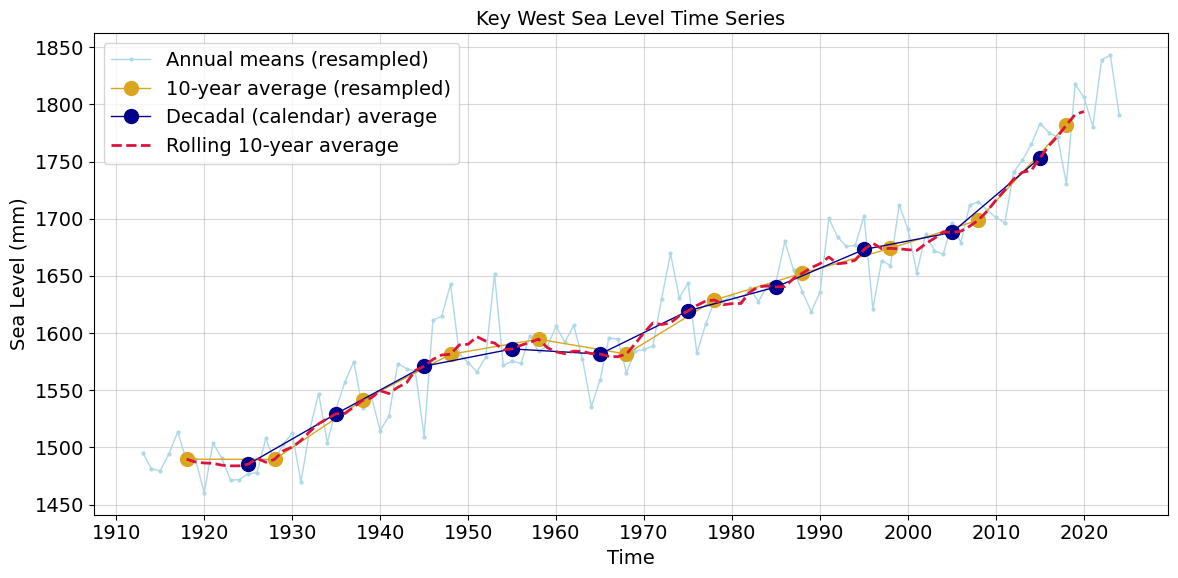

In [50]:
# copy and paste our figure from before

# create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# plot the hourly time series
#ax.plot(key_west.index.values, key_west.values, lw=0.1, label='Hourly observations (original)')

# plot resampled annual data 
ax.plot(key_west_annual.index, key_west_annual, '.-', 
            markersize=4, lw=1, c='lightblue', label='Annual means (resampled)')

# 10 year resampled data
# Notice that resampled and calendar decade averages are shifted left, because they represent the start of 
# their window
ax.plot(kw_10yr_resample.index + pd.DateOffset(years=5), kw_10yr_resample, 'o-', label='10-year average (resampled)',
       c='goldenrod', lw=1, markersize=10) 

# decadal means
ax.plot(kw_10yr_groupby.index + pd.DateOffset(years=5), kw_10yr_groupby, 'o-', label='Decadal (calendar) average', 
        c='darkblue', lw=1, markersize=10) 

# 10-year rolling averages
ax.plot(kw_10yr_rolling.index, kw_10yr_rolling.values, '--', 
        c = 'crimson', lw=2, label='Rolling 10-year average')

# add axis labels
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Sea Level (mm)', fontsize=14)

# add gridlines
ax.grid(alpha=0.5)

# add a legend
ax.legend(fontsize=14)

# add a title 
ax.set_title('Key West Sea Level Time Series', fontsize=14);

# hack for nice formatting before saving to file
plt.tight_layout()

# IF TIME:
from matplotlib.dates import YearLocator
decade_locator = YearLocator(10)
ax.xaxis.set_major_locator(decade_locator)

# save to file
plt.savefig("decadal_averages.png", dpi=150)

## Step 5 (if time): Add error bars to decadal means

In [51]:
# Recall that when we we used groupby(), we saw standard deviation as well as mean
decadal_groups.describe()

# subset using loc, like we did before
kw_10yr_groupby_std = decadal_groups.std().loc[1920:2010]

# convert index to datetime, like we did before
kw_10yr_groupby_std.index = pd.to_datetime(kw_10yr_groupby_std.index, format='%Y')
display(kw_10yr_groupby_std)

time
1920-01-01    16.113041
1930-01-01    30.006481
1940-01-01    44.376407
1950-01-01    24.666282
1960-01-01    22.627663
1970-01-01    28.060768
1980-01-01    17.277996
1990-01-01    29.186460
2000-01-01    20.249786
2010-01-01    37.452807
Name: sea_level, dtype: float64

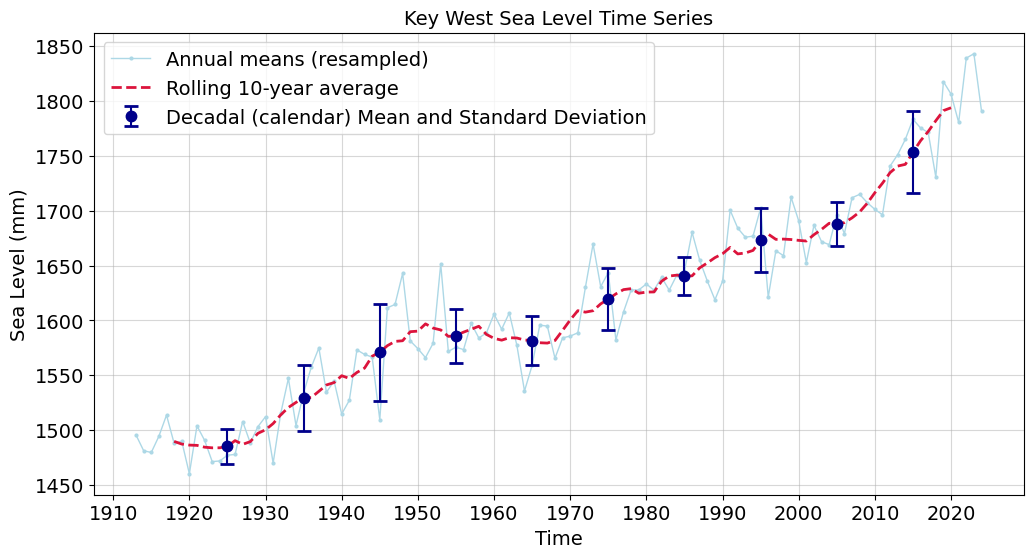

In [52]:
# copy and paste our figure from above

# create the figure
fig, ax = plt.subplots(figsize=(12, 6))

# plot the hourly time series
#ax.plot(key_west.index.values, key_west.values, lw=0.1, label='Hourly observations (original)')

# plot resampled annual data 
ax.plot(key_west_annual.index, key_west_annual, '.-', 
            markersize=4, lw=1, c='lightblue', label='Annual means (resampled)')

# 10 year resampled data
# Notice that resampled and calendar decade averages are shifted left, because they represent the start of 
# their window
#ax.plot(kw_10yr_resample.index + pd.DateOffset(years=5), kw_10yr_resample, 'o-', label='10-year average (resampled)',
#       c='goldenrod', lw=2, markersize=10) 

# decadal means
#ax.plot(kw_10yr_groupby.index + pd.DateOffset(years=5), kw_10yr_groupby, 'o-', label='Decadal (calendar) average', 
#        c='darkblue', lw=2, markersize=10) 

# 10-year rolling averages
ax.plot(kw_10yr_rolling.index, kw_10yr_rolling.values, '--', 
        c = 'crimson', lw=2, label='Rolling 10-year average')

ax.errorbar(kw_10yr_groupby.index + pd.DateOffset(years=5), kw_10yr_groupby,
            yerr=kw_10yr_groupby_std, fmt='.', markersize=15,
            capsize=5, capthick=2, c='darkblue', label='Decadal (calendar) Mean and Standard Deviation')

# add axis labels
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Sea Level (mm)', fontsize=14)

# add gridlines
ax.grid(alpha=0.5)

# add a legend
ax.legend(fontsize=14)

# add a title 
ax.set_title('Key West Sea Level Time Series', fontsize=14);

# IF TIME:
from matplotlib.dates import YearLocator
decade_locator = YearLocator(10)
ax.xaxis.set_major_locator(decade_locator)